In [1]:
import pandas as pd
import matplotlib.pyplot as plt

### Load Data

In [2]:
df = pd.read_csv('./data/data_concat.csv')\
    .drop(columns=['acceleration', 'position'])  # drop unused columns

df.time = (df.time - df.time[0]) / 1000 # set t0 to 0 and convert to seconds
df.rate = df.rate * -1 # reverse rate direction

In [3]:
df.head()

,time,torque,rate
0,0.000,0.0,29.69
1,0.017,1.0,66.69
2,0.035,1.0,61.07
3,0.052,1.0,186.73
4,0.072,1.0,109.42


In [4]:
df.describe()

,time,torque,rate
count,53352.000000,53352.000000,53352.000000
mean,522.706992,0.012204,282.453417
std,300.979223,0.672946,4611.933703
min,0.000000,-1.000000,-9386.950000
25%,262.697250,-0.700000,-2444.462500
50%,522.371000,0.000000,14.565000
75%,780.909000,0.700000,3103.072500
max,1046.287000,1.000000,10381.570000


### Process and smooth rate

In [5]:
df.rate = df.rate / 3200  # convert rate to cycles per second (?)

In [6]:
df.rate = df.rate.ewm(span=50).mean()


In [7]:
df.head()

,time,torque,rate
0,0.000,0.0,0.009278
1,0.017,1.0,0.015175
2,0.035,1.0,0.016531
3,0.052,1.0,0.027622
4,0.072,1.0,0.029043


In [8]:
df.describe()

,time,torque,rate
count,53352.000000,53352.000000,53352.000000
mean,522.706992,0.012204,0.088365
std,300.979223,0.672946,1.423490
min,0.000000,-1.000000,-2.856785
25%,262.697250,-0.700000,-0.757510
50%,522.371000,0.000000,0.000761
75%,780.909000,0.700000,0.960233
max,1046.287000,1.000000,3.162337


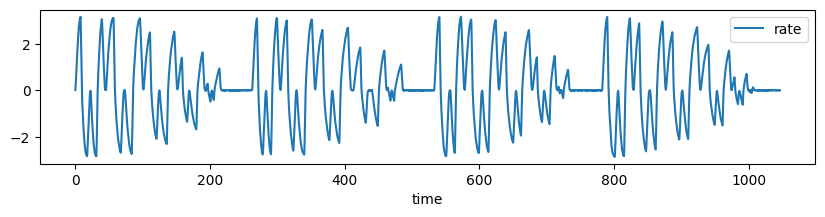

In [9]:
df.plot(x='time', y='rate', figsize=(10, 2))
plt.show()

### Calculate and smooth Acceleration

In [10]:
df['acceleration'] = df.rate.diff() / df.time.diff()

In [11]:
df.acceleration = df.acceleration.ewm(span=50).mean()

In [12]:
df.head()

,time,torque,rate,acceleration
0,0.000,0.0,0.009278,NaN
1,0.017,1.0,0.015175,0.346875
2,0.035,1.0,0.016531,0.208377
3,0.052,1.0,0.027622,0.362351
4,0.072,1.0,0.029043,0.285107


In [13]:
df.describe()

,time,torque,rate,acceleration
count,53352.000000,53352.000000,53352.000000,53351.000000
mean,522.706992,0.012204,0.088365,-0.000562
std,300.979223,0.672946,1.423490,0.431870
min,0.000000,-1.000000,-2.856785,-1.795637
25%,262.697250,-0.700000,-0.757510,-0.211784
50%,522.371000,0.000000,0.000761,0.000467
75%,780.909000,0.700000,0.960233,0.231614
max,1046.287000,1.000000,3.162337,1.609550


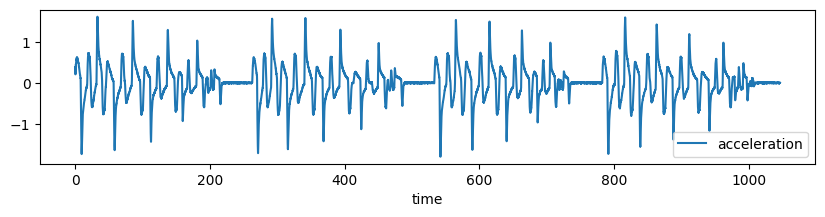

In [14]:
df.plot(x='time', y='acceleration', figsize=(10, 2))
plt.show()

### Calculate and smooth Jerk

In [15]:
df['jerk'] = df.acceleration.diff() / df.time.diff()

In [16]:
df.head()

,time,torque,rate,acceleration,jerk
0,0.000,0.0,0.009278,NaN,NaN
1,0.017,1.0,0.015175,0.346875,NaN
2,0.035,1.0,0.016531,0.208377,-7.694325
3,0.052,1.0,0.027622,0.362351,9.057297
4,0.072,1.0,0.029043,0.285107,-3.862190


In [17]:
df.describe()

,time,torque,rate,acceleration,jerk
count,53352.000000,53352.000000,53352.000000,53351.000000,53350.000000
mean,522.706992,0.012204,0.088365,-0.000562,-0.000362
std,300.979223,0.672946,1.423490,0.431870,0.348941
min,0.000000,-1.000000,-2.856785,-1.795637,-7.694325
25%,262.697250,-0.700000,-0.757510,-0.211784,-0.123780
50%,522.371000,0.000000,0.000761,0.000467,0.003393
75%,780.909000,0.700000,0.960233,0.231614,0.121467
max,1046.287000,1.000000,3.162337,1.609550,9.057297


In [18]:
df.jerk = df.jerk.ewm(span=50).mean()

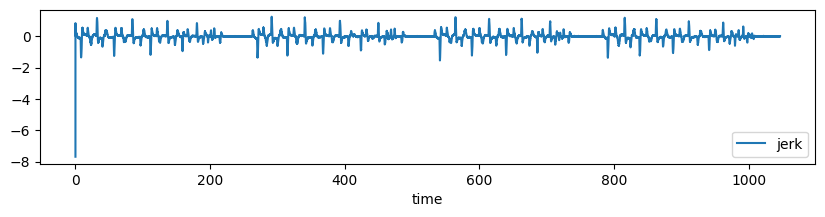

In [19]:
df.plot(x='time', y='jerk', figsize=(10, 2))
plt.show()

### Normalize

In [21]:
def get_normalize_params(data: pd.DataFrame, col: str) -> dict[str, float]:
    """ returns mean and std of a given column `col` in a dataframe `data` """
    return {'mean': data[col].mean(), 'std': data[col].std()}

def normalize(data: pd.DataFrame, col: str, params: dict[str, float]) -> pd.DataFrame:
    """ normalizes a given column `col` in a dataframe `data` using the values in `params`
        returns a new dataframe with the normalized values without modifying the original dataframe """
    opt = data.copy()
    opt[col] = (opt[col] - params['mean']) / params['std']
    return opt

def denormalize(data: pd.DataFrame, col: str, params: dict[str, float]) -> pd.DataFrame:
    """ denormalizes a given column `col` in a dataframe `data` using the values in `params`
        returns a new dataframe with the denormalized values without modifying the original dataframe """
    opt = data.copy()
    opt[col] = opt[col] * params['std'] + params['mean']
    return opt

In [22]:
rate_norm_params = get_normalize_params(df, 'rate')
acc_norm_params = get_normalize_params(df, 'acceleration')
da_dt_norm_params = get_normalize_params(df, 'jerk')

df_norm = df.copy()

df_norm = normalize(df_norm, 'rate', rate_norm_params)
df_norm = normalize(df_norm, 'acceleration', acc_norm_params)
df_norm = normalize(df_norm, 'jerk', da_dt_norm_params)

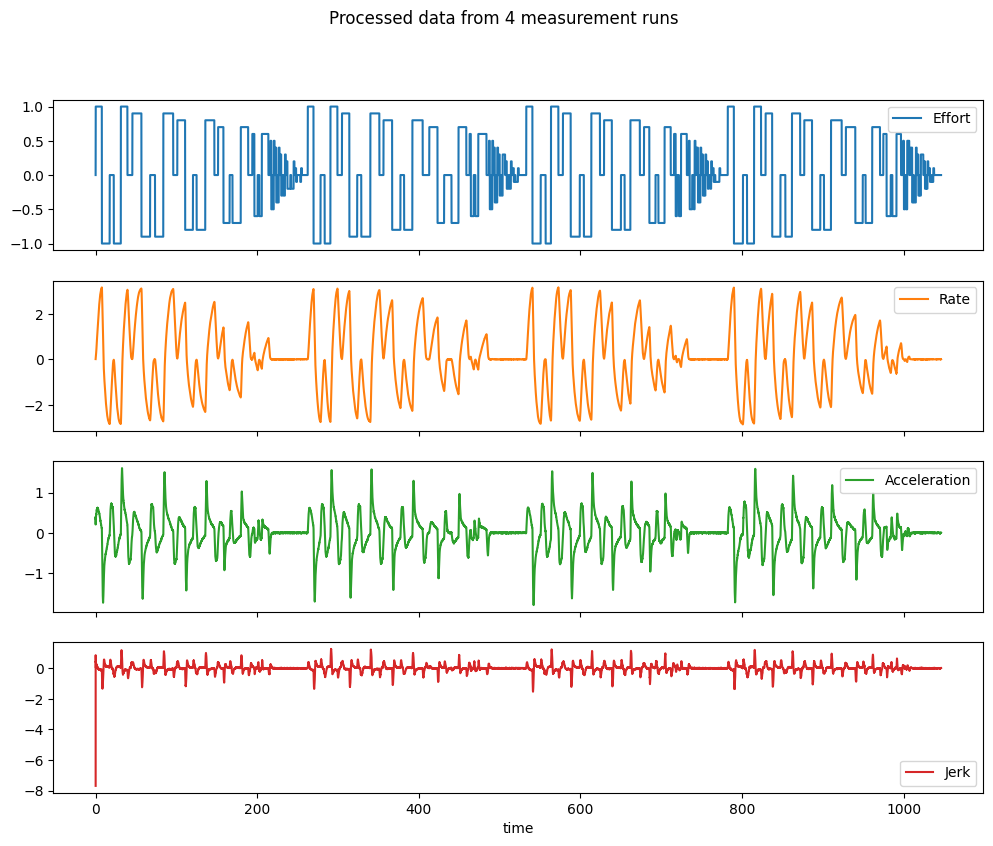

In [23]:
df.plot(x='time', y=['torque','rate', 'acceleration', 'jerk'], subplots=True, figsize=(12, 9), label=['Effort', 'Rate', 'Acceleration', 'Jerk'], title='Processed data from 4 measurement runs')
plt.show()

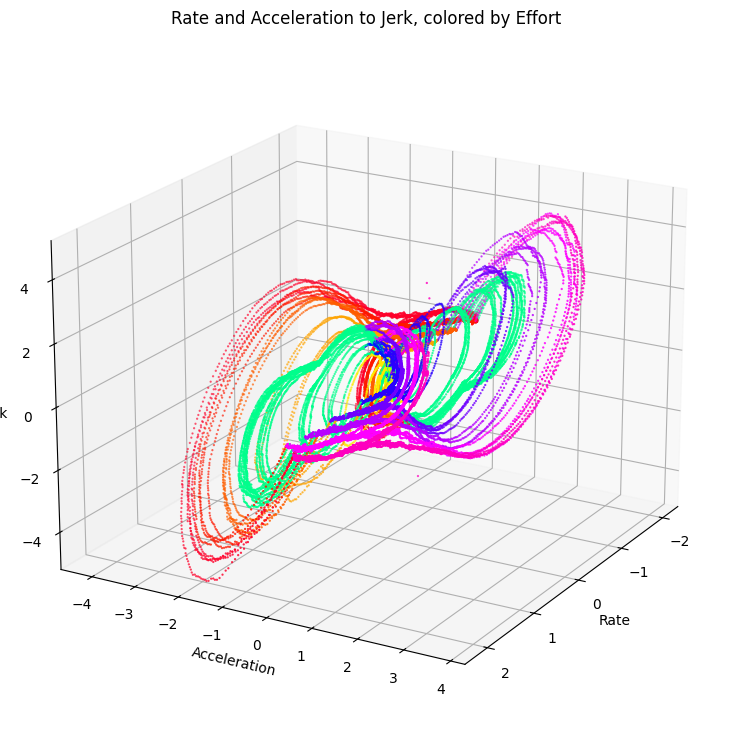

In [26]:
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(left=0.1, right=0.99, bottom=0, top=1)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_norm.rate, df_norm.acceleration, df_norm.jerk, s=0.4, c=df_norm.torque, cmap='gist_rainbow')
ax.set_zlim(-5, 5)
ax.view_init(elev=20, azim=30)
ax.set_xlabel('Rate')
ax.set_ylabel('Acceleration')
ax.set_zlabel('Jerk')
ax.set_title('Rate and Acceleration to Jerk, colored by Effort')

ax.set
plt.show()